# Image Downloads



This is a tutorial for downloading street-level imagery using the Google Street View API. This tutorial was developed by researchers at MIT's Senseable Cities Lab (Director: Professor Carlo Ratti) for the 11.320 Digital City Design Lab course in Spring 2023. See https://senseable.mit.edu/ to learn more about the lab's work.

If you don't have one already, you will need to set up a Google Cloud account with the [Google Street View Static API](https://developers.google.com/maps/documentation/streetview/overview) enabled. As of September 2023, the Street View Static API offers a $200 free monthly credit, which is sufficient to download ~28,571 images/month or ~357 km of street network (at a 50m sampling interval).

The methodology below uses the following steps:
1. Extract the street network from OpenStreetMap
2. Randomly generate request points at 50m intervals across the street network
3. Compile image metadata, including panoramic ID (panoID), date/time of capture, and coordinates
4. Download images in four panoramic angles at each request point

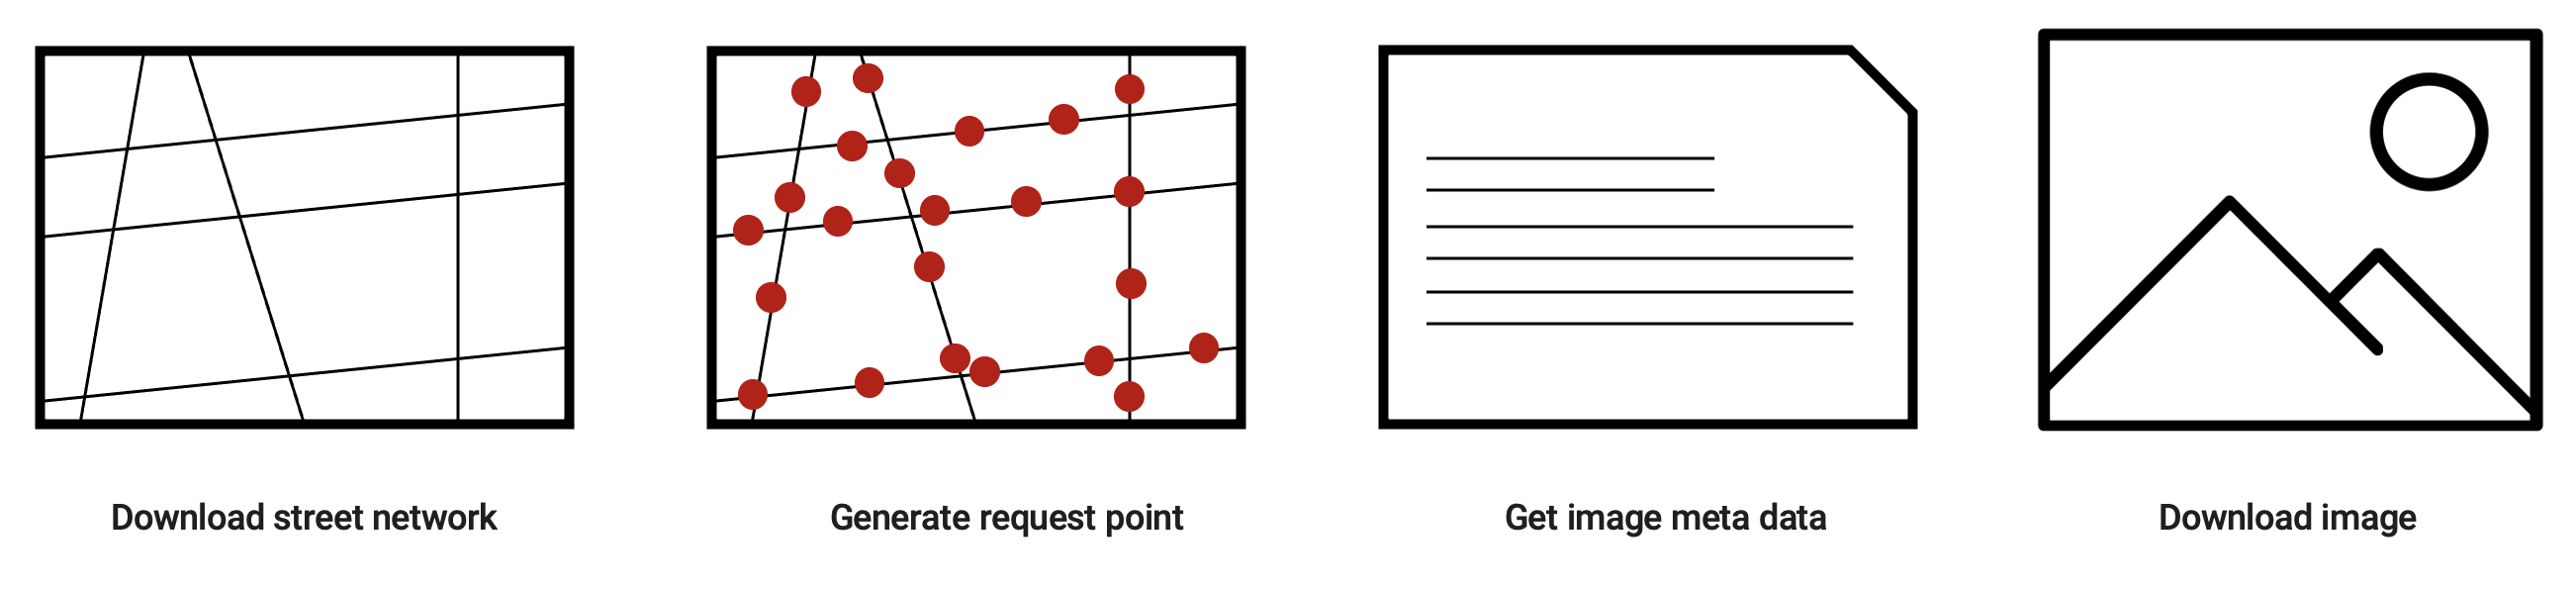


## 0 Setup
First, run the next code block to setup.

In [ ]:
!pip install osmnx &> /dev/null
!pip install matplotlib==3.1.3 &> /dev/null

In [ ]:
import os, sys
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
save_path = "[XXXXX]"

In [ ]:
if not os.path.exists(save_path):
    os.mkdir(save_path)

Run the next code block to import libraries for this lab.

In [ ]:
import osmnx as ox
!pip install numpy
import numpy as np
import pandas as pd
import geopandas as gpd

from PIL import Image
from io import BytesIO

import requests
from tqdm import tqdm
import time
import matplotlib.pyplot as plt


## 1 Generate street network

Code below downloads street network from openstreetmap

In [ ]:
def obtain_street_network_grid(north, south, east, west):
  """
  This function downloads street network within a rectangular area
  input: north, south, east, west coordinates of the area
  output: GeoDataFrame, each row represents one street segment
  """
  # obtain street network from OpenStreetMap
  # network_type will simplify the network, here we only download drive way
  G = ox.graph_from_bbox(north, south, east, west, truncate_by_edge=True, network_type='drive')
  # convert downloaded street network to GeoDataFrame
  _, edge = ox.utils_graph.graph_to_gdfs(G)
  # plot downloaded street network
  ox.plot_graph(G)

  return edge


In [ ]:
# north, south, east, west
street = obtain_street_network_grid(NORTH, SOUTH, EAST, WEST)

## 2 Generate points on street to request GSV

In [ ]:
def street2Point(roadDF):
    """
    This function generates random points for all street with a 50-meter interval
    input: GeoDataFrame, this is what we obtained from Step 1
    output: DataFrame with three columns: [id, lat, lon], each row represents one point
    """
    roadDF['ref'] = 1
    roadDDF = roadDF.dissolve(by='ref')
    #include comment on download interval
    interval_meters = 0.0005
    totalLength = roadDDF.geometry.length.values

    pointList = []
    for dist in np.arange(0, totalLength, interval_meters):
        pointList.append(roadDDF.geometry.interpolate(dist))

    pts = pd.DataFrame(pointList)
    pts['id'] = pts.index

    pts.columns=[ 'geometry','id']

    pts["x"] = pts.geometry.apply(lambda x: str(x).split(' ')[1][1:])
    pts["y"] = pts.geometry.apply(lambda x: str(x).split(' ')[2][:-1])
    pts_all = pts.drop(["geometry", "id"], axis=1)

    pts_all.x = pts_all.x.astype('float64')
    pts_all.y = pts_all.y.astype('float64')
    pts_all.x = pts_all.x.apply(lambda x: np.round(x, 5))
    pts_all.y = pts_all.y.apply(lambda x: np.round(x, 5))

    gdf = gpd.points_from_xy(pts_all.x, pts_all.y)
    pts_shp = gpd.GeoDataFrame(pd.DataFrame(dict(geometry=gdf)))
    pts_shp["lng"] = pts_shp.geometry.x
    pts_shp["lat"] = pts_shp.geometry.y
    pts_shp = pts_shp.drop_duplicates(subset=["lng","lat"])
    pts_shp = pts_shp.reset_index()
    pts_shp = pts_shp.drop(['geometry'], axis=1)
    pts_shp.columns=["id", "lon", "lat"]

    return pts_shp

In [ ]:
requestPoint = street2Point(street)
display(requestPoint.head(3))

In [ ]:
requestPoint.info()

## 3 Request Google Street View image metadata

Starting from this step, you will need to feed your GSV API key in order to make requests to GSV server. In next

In [ ]:
# Starting from this step, you will need to feed your GSV API key in order to make requests to GSV server. In the line below, please replace 'xxx' with your own key
apiKey = 'xxx'

In [ ]:
def GSV_meta_single(lat, lon, apiKey):
  """
  This function obtains GSV metadata at one single request point
  input: latitude and longitude of the request point, api key of your Google Cloud account
  output: dictionary with time, latitude, longitude and panoID of the GSV at the request point
  """
  # original request url for API call
  meta_url = "https://maps.googleapis.com/maps/api/streetview/metadata?size=600x400&location={},{}&key={}"
  # format the request url with feeded parameters
  request_url = meta_url.format(lat, lon, apiKey)
  try:
      # request and format the metadata
      response = requests.get(request_url).json()
      # return metadata if GSV exists
      return {'date':response['date'], 'lat':response['location']['lat'], 'lon':response['location']['lng'], 'panoID':response['pano_id']}
  except:
      # if no GSV is found or any other error happens, return None
      return None

In [ ]:
# construct a list to store all information
metas = []
# iterate over requestPoint DataFrame and request GSV metadata
for i, row in tqdm(requestPoint.iterrows()):
    # obtain metadata for each point
    meta = GSV_meta_single(row['lat'], row['lon'], apiKey)
    # if GSV meta data is successfully downloaded and formatted, save the information
    if meta != None:
        metas.append(meta)
    # time.sleep(0.1)

# convert stored information to DataFrame
panoidDF = pd.DataFrame(metas, columns=['date', 'lat', 'lon', 'panoID'])

In [ ]:
# inspect downloaded GSV meta data
panoidDF.head(5)

In [ ]:
panoidDF.info()

In [ ]:
# optional, save meta data for future use
#check protocol 3
panoidDF.to_csv("[filepath]/xyz.csv")

## 4 Request Google Street View images

In [ ]:
def GSV_single(panoID, heading, apiKey, pitch=0, fov=90, width=600, height=400):
  """
  This function downloads GSV image with panoID and other customized parameters
  input:
    panoID: unique ID obtained from GSV meta data
    heading: horizontal angle the camera is pointing at
    pitch: vertical angle the camera is pointing at
    fov: zoom level of the image
  output:
    PIL Image object
  """
  # format the request url for downloading image
  request_url = "https://maps.googleapis.com/maps/api/streetview?size={}x{}&pano={}&heading={}&fov={}&pitch={}&key={}".format(width, height, panoID, heading, fov, pitch, apiKey)
  # request image and return
  try:
      response = requests.get(request_url)
      return Image.open(BytesIO(response.content))
  except:
      return None

In [ ]:
for idx, row in tqdm(panoidDF.iterrows()):
    for heading in [0,90,180,270]:
      img = GSV_single(panoID=row['panoID'], apiKey=apiKey, heading=heading)
      img.save(os.path.join(save_path, '{}_{}.jpg'.format(row['panoID'], heading)), 'jpeg')

VISUALIZE DOWNLOAD LOCATIONS

In [ ]:
import folium
import io

In [ ]:
zoom_level = 15

In [ ]:
center = [panoidDF['lat'].mean(), panoidDF['lon'].mean()]

In [ ]:
# include visualisation
theme = 'CartoDB positron'
#theme  = 'openstreetmap'
#theme = 'cartodbpositron'
map0 = folium.Map(location=center,tiles=theme,zoom_start=zoom_level)
# Display the map0

# 2.5 Paint the dataframe data with dots on the map

# Read the Lat and Lng and paint with color

for index, row in panoidDF.iterrows():
  folium.CircleMarker([row['lat'], row['lon']],radius=.01,fill=True, color='green',opacity=1, fill_color='green',fill_opacity=1).add_to(map0)

map0